In [ ]:
#https://www.relataly.com/predictive-maintenance-predicting-machine-failure-with-python/10618/
# A tutorial for this file is available at www.relataly.com
# Tested with Python 3.9.13, Matplotlib 3.6.2, Scikit-learn 1.2, Seaborn 0.12.1, numpy 1.21.5, xgboost 1.7.2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support as score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.utils import compute_sample_weight
from xgboost import XGBClassifier

# load the train data
path = '/data/iot/classification/'
df = pd.read_csv('/content/predictive_maintenance.csv')

# define the target
target_name='Failure Type'

# drop a redundant columns
df.drop(columns=['Target'], inplace=True)

# print a summary of the train data
print(df.shape[0])
df.head(3)

10000


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,No Failure


In [ ]:
# check for missing values
def print_missing_values(df):
    null_df = pd.DataFrame(df.isna().sum(), columns=['null_values']).sort_values(['null_values'], ascending=False)
    fig = plt.subplots(figsize=(16, 6))
    ax = sns.barplot(data=null_df, x='null_values', y=null_df.index, color='royalblue')
    pct_values = [' {:g}'.format(elm) + ' ({:.1%})'.format(elm/len(df)) for elm in list(null_df['null_values'])]
    ax.set_title('Overview of missing values')
    ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)

if df.isna().sum().sum() > 0:
    print_missing_values(df)
else:
    print('no missing values')

# drop all columns with more than 5% missing values
for col_name in df.columns:
    if df[col_name].isna().sum()/df.shape[0] > 0.05:
        df.drop(columns=[col_name], inplace=True)

df.columns

no missing values


Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Failure Type'],
      dtype='object')

In [ ]:
# drop id columns
df_base = df.drop(columns=['Product ID', 'UDI'])

# adjust column names
df_base.rename(columns={'Air temperature [K]': 'air_temperature',
                        'Process temperature [K]': 'process_temperature',
                        'Rotational speed [rpm]':'rotational_speed',
                        'Torque [Nm]': 'torque',
                        'Tool wear [min]': 'tool_wear'}, inplace=True)
df_base.head()

,Type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,Failure Type
0,M,298.1,308.6,1551,42.8,0,No Failure
1,L,298.2,308.7,1408,46.3,3,No Failure
2,L,298.1,308.5,1498,49.4,5,No Failure
3,L,298.2,308.6,1433,39.5,7,No Failure
4,L,298.2,308.7,1408,40.0,9,No Failure


In [ ]:
# display class distribution of the target variable
px.histogram(df_base, y="Failure Type", color="Failure Type")

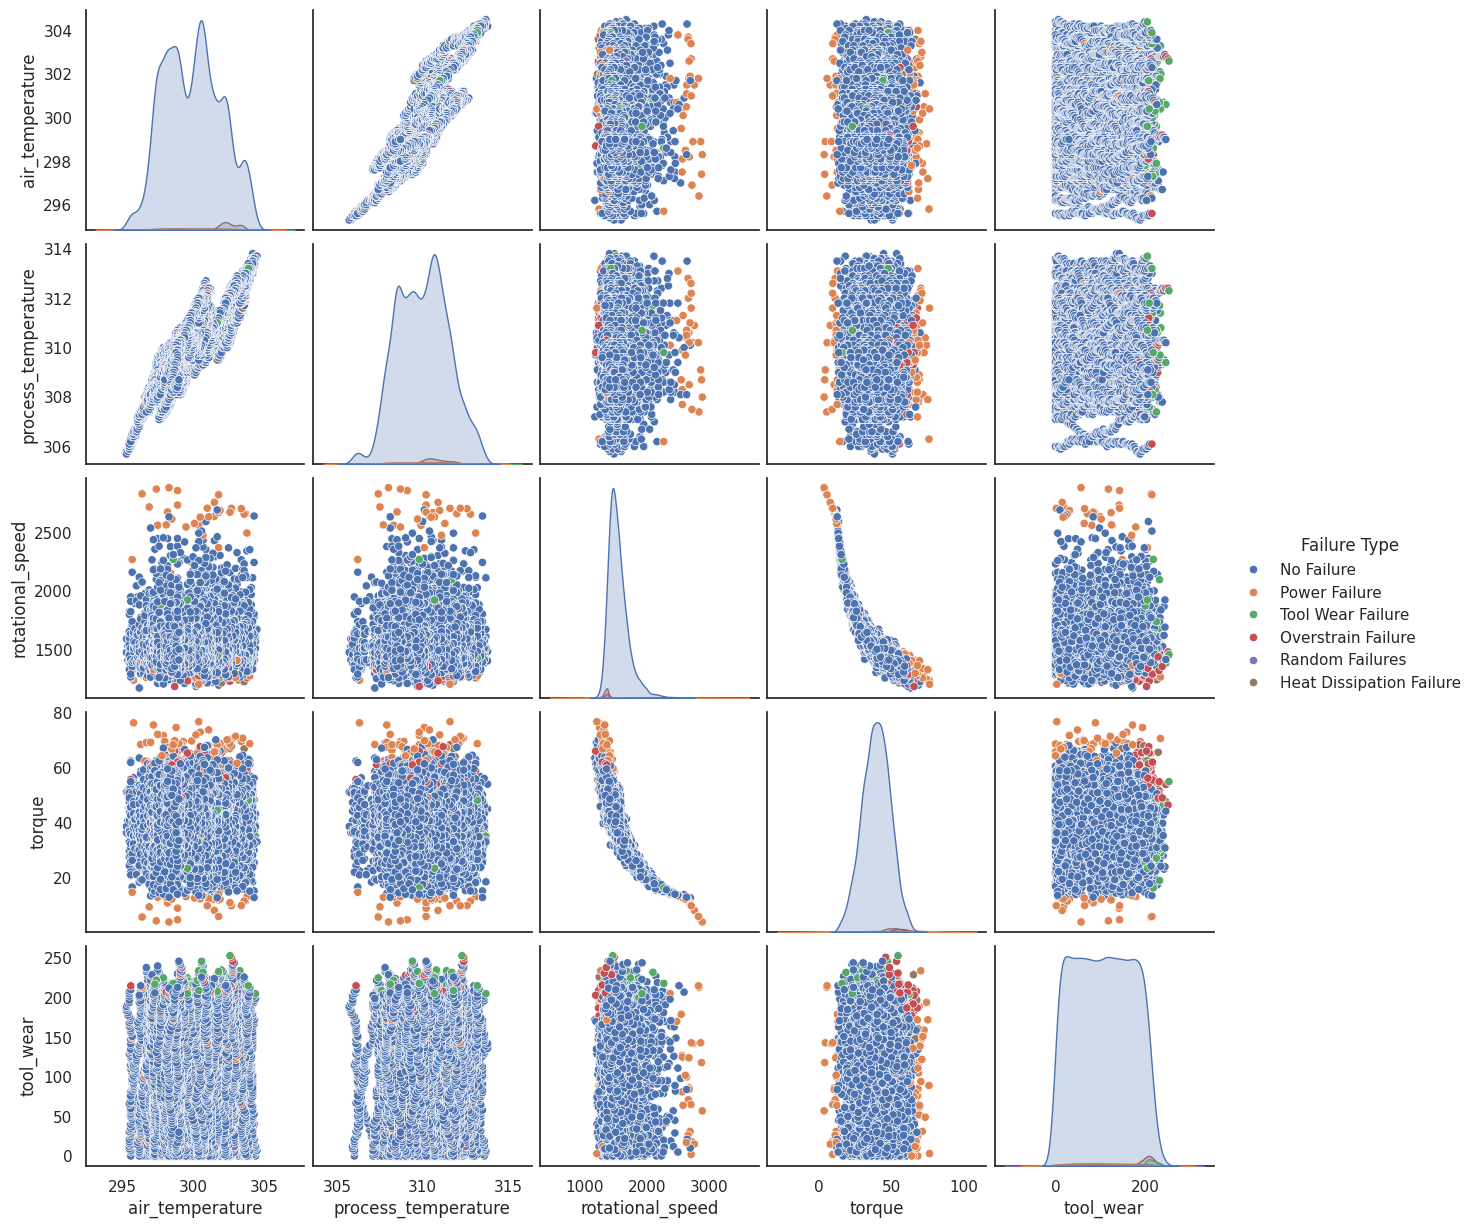

In [ ]:
# pairplots on failure type
sns.pairplot(df_base, height=2.5, hue='Failure Type')

<ipython-input-76-e766ef847098>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

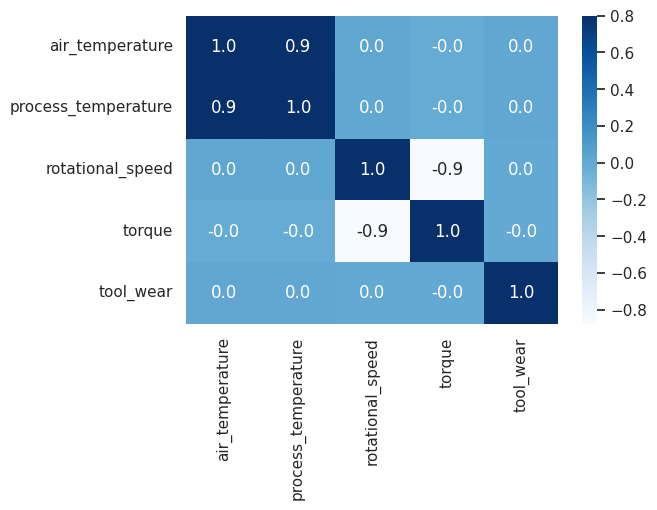

In [ ]:
# correlation plot
plt.figure(figsize=(6,4))
sns.heatmap(df_base.corr(), cbar=True, fmt='.1f', vmax=0.8, annot=True, cmap='Blues')

In [ ]:
# create histograms for feature columns separated by target column
def create_histogram(column_name):
    plt.figure(figsize=(16,6))
    return px.box(data_frame=df_base, y=column_name, color='Failure Type', points="all", width=1200)

create_histogram('air_temperature')

<Figure size 1600x600 with 0 Axes>

In [ ]:
create_histogram('process_temperature')

<Figure size 1600x600 with 0 Axes>

In [ ]:
create_histogram('rotational_speed')

<Figure size 1600x600 with 0 Axes>

In [ ]:
create_histogram('torque')

<Figure size 1600x600 with 0 Axes>

In [ ]:
create_histogram('tool_wear')

<Figure size 1600x600 with 0 Axes>

In [ ]:
def data_preparation(df_base, target_name):
    df = df_base.dropna()

    df['target_name_encoded'] = df[target_name].replace({'No Failure': 0, 'Power Failure': 1, 'Tool Wear Failure': 2, 'Overstrain Failure': 3, 'Random Failures': 4, 'Heat Dissipation Failure': 5})
    df['Type'].replace({'L': 0, 'M': 1, 'H': 2}, inplace=True)
    X = df.drop(columns=[target_name, 'target_name_encoded'])
    y = df['target_name_encoded'] #Prediction label

    # split the data into x_train and y_train data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

    # print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
    print('train: ', X_train.shape, y_train.shape)
    print('test: ', X_test.shape, y_test.shape)
    return X, y, X_train, X_test, y_train, y_test

# remove target from training data
X, y, X_train, X_test, y_train, y_test = data_preparation(df_base, target_name)

train:  (7000, 6) (7000,)
test:  (3000, 6) (3000,)


In [ ]:
weight_train = compute_sample_weight('balanced', y_train)
weight_test = compute_sample_weight('balanced', y_test)

xgb_clf = XGBClassifier(booster='gbtree',
                        #tree_method='gpu_hist',
                        sampling_method='gradient_based',
                        eval_metric='aucpr',
                        objective='multi:softmax',
                        device="cuda",
                        num_class=6)
# fit the model to the data
xgb_clf.fit(X_train, y_train.ravel(), sample_weight=weight_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=6,
              num_parallel_tree=None, ...)

In [ ]:
# score the model with the test dataset
score = xgb_clf.score(X_test, y_test.ravel(), sample_weight=weight_test)

# predict on the test dataset
y_pred = xgb_clf.predict(X_test)

# print a classification report
results_log = classification_report(y_test, y_pred)
print(results_log)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:42:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2903
           1       0.64      0.88      0.74        24
           2       0.04      0.08      0.06        12
           3       0.77      0.89      0.83        27
           4       0.00      0.00      0.00         4
           5       0.76      0.97      0.85        30

    accuracy                           0.98      3000
   macro avg       0.53      0.63      0.58      3000
weighted avg       0.98      0.98      0.98      3000



<Axes: xlabel='Predicted', ylabel='Actual'>

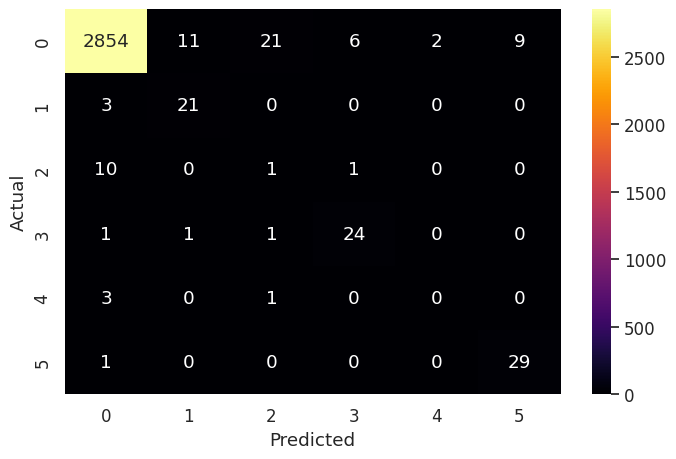

In [ ]:
# create predictions on the test dataset
y_pred = xgb_clf.predict(X_test)

# print a multi-Class Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8, 5))
sns.set(font_scale=1.1) #for label size
sns.heatmap(df_cm, cbar=True, cmap= "inferno", annot=True, fmt='.0f')

In [ ]:
# cross validation
scores  = cross_validate(xgb_clf, X_train, y_train, cv=10, scoring="f1_weighted", fit_params={ "sample_weight" :weight_train})
scores_df = pd.DataFrame(scores)
px.bar(x=scores_df.index, y=scores_df.test_score, width=800)